## Batch NormalizationとLayer Normarlization

## Hook

### .register_hook

In [1]:
# ライブラリ
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
import utils
import time

In [ ]:
a = torch.ones(5, requires_grad=True)
b = 2*a
# 中間gradを保持
b.retain_grad()

# ここに追加

def print_grad(grad):
    print(grad)
b.register_hook(print_grad)

"""
lambda関数を使って省略
b.register_hook(lambda grad: print(grad))
"""

c = b.mean()

# backward
c.backward()


In [ ]:
print(a)
print(b)
print(c)

In [ ]:
print(a.grad)
print(b.grad)

### .register_forward_hook()

In [19]:
# modelを定義する
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(), 

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Flatten(),
    # 128 -> 32
    nn.Linear(128, 10)
    
)


In [20]:
outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape
    

In [21]:
# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    # print(name, module)
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_forward_hook(partial(save_output, name))
        

In [22]:
def print_hooks(model):
    for name , module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook : {hook}')
    
    for name , module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook : {hook}')

In [23]:
print_hooks(conv_model)

Module 0 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '0')
Module 1 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '1')
Module 2 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '2')
Module 3 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '3')
Module 4 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '4')
Module 5 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '5')
Module 6 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '6')
Module 7 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '7')
Module 8 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '8')
Module 9 has forward hook : functools.partial(<function save_output at 0x7ffff9bd5dc0>, '9')


In [24]:
from functools import partial

# 元となる関数を定義
def power(base, exponent):
    return base ** exponent

# 部分適用した関数を適用
square = partial(power, exponent=2)

# 部分適用した関数の利用
print(square(5))  # 出力25


25


### forwardでhookを発動

In [ ]:
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

In [ ]:
outputs

## .register_full_backward_hook()

In [ ]:
grads = {}
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in

# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    # print(name, module)
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_full_backward_hook(partial(save_grad_in, name))
        

In [ ]:
print_hooks(conv_model)

In [ ]:
# backward 
X = torch.rand((1, 1, 28, 28))
output = conv_model(X)
loss = output.mean()
loss.backward()

In [ ]:
grads

In [ ]:
## Activationの分布

In [2]:
# model 
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 32x2x2
    nn.Flatten(),
    nn.Linear(128, 10)

)

outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape

# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    if name: 
        module.register_forward_hook(partial(save_output, name))
        

In [11]:
# forward 
# for module in conv_model:
#     print(module)
# # relu分のリストを作成
# act_means = [[]  for module in conv_model if isinstance(module, nn.ReLU)]
# act_stds = [[]  for module in conv_model if isinstance(module, nn.ReLU)]

# def save_out_stats(i, module, inp, out):
#     act_means[i].append(out.mean().item())
#     act_stds[i].append(out.std().item())
    
# relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
# for i, relu in enumerate(relu_layers):
#     relu.register_forward_hook(partial(save_out_stats, i))

# 上記のものをclass化する

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

In [12]:
act_stats = ActivationStatistics(conv_model)

NameError: name 'conv_model' is not defined

In [ ]:
[module for module in conv_model if isinstance(module, nn.ReLU)]

In [2]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
])



train_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = False, download=True, transform=transform)

# dataloader 
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1024, num_workers=4)


In [ ]:
opt = optim.SGD(conv_model.parameters(), lr=0.6)

In [ ]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)


In [ ]:
act_means, act_stds = act_stats.get_statstics()

In [ ]:
act_stats.plot_statistics()

In [ ]:
# act_means   # [[], [], [], []]
for act_mean in act_means:
    plt.plot(act_mean)

plt.legend(range(len(act_means)))

In [ ]:
# act_means   # [[], [], [], []]
for act_std in act_stds:
    plt.plot(act_std)

plt.legend(range(len(act_std)))

このグラフから何を言っているのかと
1層目のReLU層の平均値をみると、stepがめっちゃ上がって下がって、いる
-> 学習がしにくい状況になっている
つまり、分布が変わっている
各Activation分布を見ることで、学習が滑らかに進んではいない
平均が上がったり、下がったりしている -> 内部共変量が起きている

## Batch Normスクラッチ実装

In [5]:
# 全結合層の場合はX.shape = [b, out_feature]
# dim=(0)で平均、分散を求める
def batch_norm(X, gamma=1, beta=0, eps=1e-5):

    # dim=(0, 2, 3)はそれぞれの軸で平均を取る -> それぞれのchannelごとの平均
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = X.var(dim=(0, 2, 3), keepdim=True)
    # 分母0を防ぐために微小の値を足す
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma * X_norm + beta

In [ ]:
X = torch.randn(8, 3, 16, 16)
X.shape


In [4]:
eps = 1e-6

# dim=(0, 2, 3)はそれぞれの軸で平均を取る -> それぞれのchannelごとの平均
mean = X.mean(dim=(0, 2, 3), keepdim=True)
var = X.var(dim=(0, 2, 3), keepdim=True)
# 分母0を防ぐために微小の値を足す
X_norm = (X - mean) / torch.sqrt(var + eps)

NameError: name 'X' is not defined

In [21]:
X, y = train_dataset[0]
X.shape

torch.Size([1, 28, 28])

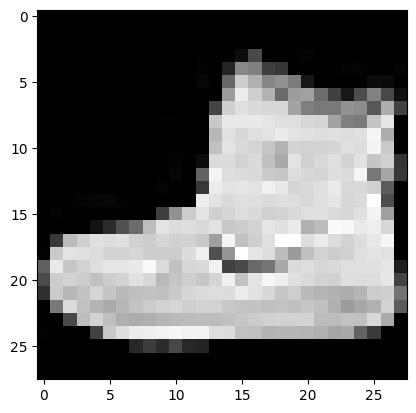

In [22]:
# 0 ~ 1に正規化
X = X / 2 + 0.5

# 可視化
plt.imshow(np.transpose(X, (1, 2, 0)), cmap='gray')

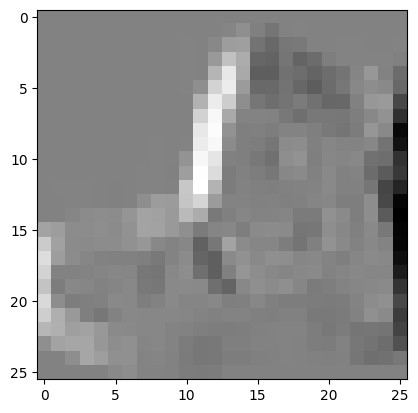

In [23]:
# 特徴量を抽出
def apply_filter(im, filter):
    output_data = []
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)

    return torch.tensor(output_data)

left_edge_filter = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

def relu(X):
    return torch.clamp(X, min=0)

# rankを二つ
X_ = X[0, :, :]

conv_out = apply_filter(X_, left_edge_filter)
plt.imshow(conv_out, cmap='gray')

In [9]:
# 平均とstd見る
print(conv_out.mean(), conv_out.std())

tensor(0.0442) tensor(0.6041)


In [10]:
conv_out.shape

torch.Size([26, 26])

In [11]:


conv_out = conv_out[None, None, :, :]
norm_out = batch_norm(conv_out)



In [12]:
norm_out.shape

torch.Size([1, 1, 26, 26])

In [13]:
print(norm_out.mean(), norm_out.std())

tensor(-1.6224e-08) tensor(1.0000)


In [14]:
# plt.imshow(norm_out[0, 0, :, :], cmap='gray')

In [15]:
# reluをかます
relu_out = relu(norm_out)
relu_out.shape

torch.Size([1, 1, 26, 26])

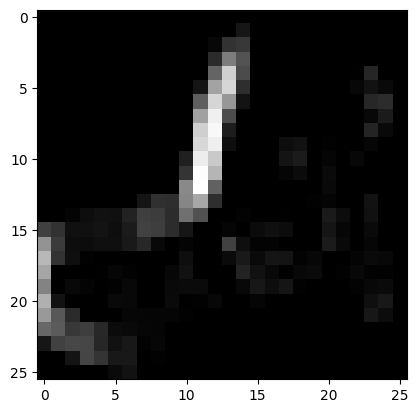

In [16]:
plt.imshow(relu_out[0, 0, :, :], cmap='gray')

## nn.BatchNorm2d()

In [17]:
X, y = next(iter(train_loader))

# たてよこ半分にするconv2d
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
norm_out = nn.BatchNorm2d(8)(conv_out)

In [18]:
X.shape

torch.Size([1024, 1, 28, 28])

In [19]:
print('平均', conv_out.mean(), '標準偏差', conv_out.std())
print('batch norm後の平均', norm_out.mean(dim=(0, 2, 3)), 'batch norm後の標準偏差', norm_out.std(dim=(0, 2, 3)))


平均 tensor(-0.1087, grad_fn=<MeanBackward0>) 標準偏差 tensor(0.5746, grad_fn=<StdBackward0>)
batch norm後の平均 tensor([ 7.2605e-09, -3.8583e-09, -2.7750e-09, -1.7139e-08,  7.5836e-09,
        -4.4703e-08,  2.4119e-08,  1.3039e-08], grad_fn=<MeanBackward1>) batch norm後の標準偏差 tensor([1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<StdBackward0>)


In [20]:
# batch normのパラメータ確認する
list(nn.BatchNorm2d(8).parameters())

# 出力からわかるように2つのパラメータを持つ -> scaleのガンマ, シフトのベータ
# 今回は初期値は(scale, shift) = (1, 0)に設定した。

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [21]:
# modelにbatch_normを適用する
def get_conv_model():
    conv_model = nn.Sequential(
        # 1x28x28
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(),

        # 4x14x14
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),

        # 8x7x7
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),

        # 16x4x4
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # 32x2x2
        nn.Flatten(),
        nn.Linear(128, 10)
    )

In [39]:
# batchnormを適用したmodel
def get_gap_conv_model():
    return nn.Sequential(
    # 1x28x28 
    nn.Conv2d(1,4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),

    # 8x7x7
    nn.Conv2d(8,16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # 32x2x2
    # nn.Flatten() <- GAP -> 32x1x1
    nn.AdaptiveAvgPool2d(1),
    # 32xx1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10) 
)

In [40]:

conv_model_w_bn = get_gap_conv_model()
act_stats = ActivationStatistics(conv_model_w_bn)

In [42]:
opt = optim.SGD(conv_model_w_bn.parameters(), lr=0.6)
# learn
train_losses, val_losses, val_accuracy = utils.learn(conv_model_w_bn, train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)

epoch: 0: train error: 0.9310743424852016, validation error: 0.5989604771137238, validation accuracy: 0.7869758427143096


epoch: 1: train error: 0.4931398998882811, validation error: 0.590716540813446, validation accuracy: 0.7981285870075225


epoch: 2: train error: 0.41752166465177376, validation error: 0.4228111058473587, validation accuracy: 0.8471480369567871


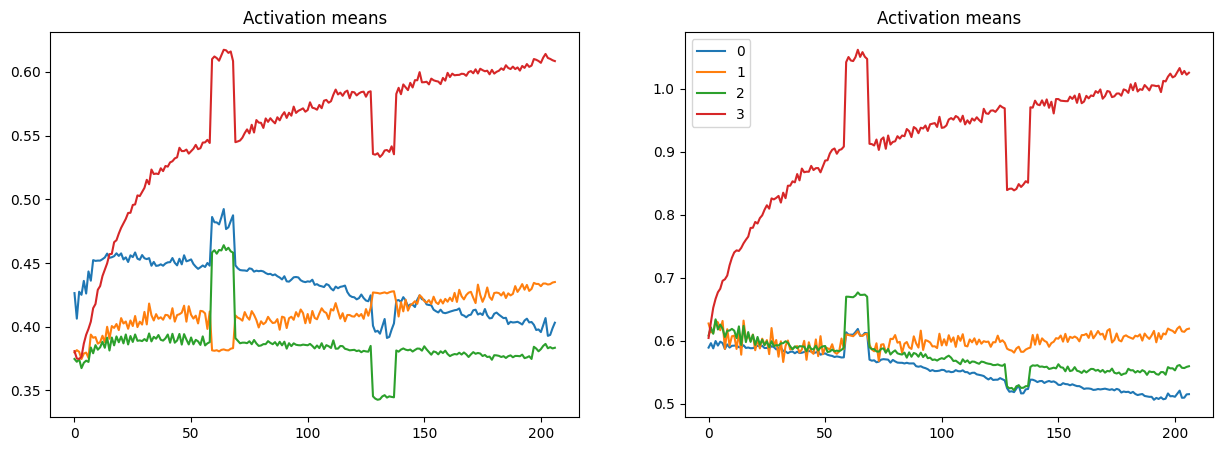

In [44]:
# 正規化することで1epochから正解率が高い -> 学習率を高くできて効率よく学習できる -> 早く収束する
act_stats.plot_statistics()

## Layer Normalizationをスクラッチで実装

In [3]:
class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [15]:
# 全結合層の場合はX.shape = [b, out_feature]
# dim=(0)で平均、分散を求める
def batch_norm(X, gamma=1, beta=0, eps=1e-5):

    # dim=(0, 2, 3)はそれぞれの軸で平均を取る -> それぞれのchannelごとの平均
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = X.var(dim=(0, 2, 3), keepdim=True)
    # 分母0を防ぐために微小の値を足す
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma * X_norm + beta

    
def LayerNormalization(X, gamma=1, beta=0, eps=1e-5):
    mean = X.mean(dim=(1,2,3), keepdim=True)
    var = X.var(dim=(1,2,3) ,keepdim=True)
    # 正規化
    X_norm = (X - mean) / torch.sqrt(var + eps)
    return gamma * X_norm + beta


In [16]:
X = torch.randn(2, 3, 4, 4)
norm_out = LayerNormalization(X, gamma=1, beta=0)
norm_out

tensor([[[[ 0.5176, -0.3393,  0.4106, -0.4437],
          [-0.4256, -1.3078,  2.4935, -0.9745],
          [ 2.4230, -0.9164, -0.0818,  0.3815],
          [-1.9507,  1.0775, -0.2051, -0.5242]],

         [[ 2.3819, -1.2775,  0.5256,  0.6030],
          [-1.4883,  0.7958, -1.1899,  0.2708],
          [ 0.0508, -2.0548, -0.0158,  0.2949],
          [-0.8502,  0.5806, -0.1394,  0.6054]],

         [[ 0.6434,  0.4912,  0.8528, -0.8391],
          [-0.5217,  0.2764, -0.7778, -0.8830],
          [-0.5897, -0.4558,  0.6328,  1.3189],
          [ 0.5006, -0.1525, -0.1615,  0.4371]]],


        [[[-1.9922, -0.6024, -0.9246,  1.5843],
          [ 0.8562, -0.1459, -1.3183,  1.0175],
          [ 2.0547,  0.5699,  1.6056, -1.3340],
          [-0.0572,  1.5772,  1.3214, -0.0408]],

         [[-1.8906,  0.6475,  0.3988,  0.4511],
          [-0.0211, -0.1609,  0.0693, -0.2659],
          [ 0.6400,  0.1574, -1.3714, -1.4184],
          [ 0.5414, -0.6449,  0.6319, -0.4860]],

         [[-0.4115,  0.1732,

In [10]:
# データごと(横)に平均を取る
X.mean(dim=1)

tensor([2., 5.])

In [ ]:
# 全結合層の場合はX.shape = [b, out_feature]
# dim=(0)で平均、分散を求める
def batch_norm(X, gamma=1, beta=0, eps=1e-5):

    # dim=(0, 2, 3)はそれぞれの軸で平均を取る -> それぞれのchannelごとの平均
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = X.var(dim=(0, 2, 3), keepdim=True)
    # 分母0を防ぐために微小の値を足す
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma * X_norm + beta

## PytorchでのLayerNormalizationを実装

In [3]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
norm_out = nn.LayerNorm([8,14, 14])(conv_out)

In [4]:
print(conv_out.shape)
print(norm_out.shape)

torch.Size([1024, 8, 14, 14])
torch.Size([1024, 8, 14, 14])


In [5]:
# しっかり正規化していることわかる
print(conv_out[0].mean(), conv_out[0].std())
print(norm_out[0].mean(), norm_out[0].std())

tensor(0.0014, grad_fn=<MeanBackward0>) tensor(0.3220, grad_fn=<StdBackward0>)
tensor(1.5813e-08, grad_fn=<MeanBackward0>) tensor(1.0003, grad_fn=<StdBackward0>)


In [14]:
# modelにlayernormを適用する
def get_conv_model_ln():
    return nn.Sequential(
        # 1x28x28
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([4, 14, 14]),
        nn.ReLU(),

        # 4x14x14
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([8, 7, 7]),
        nn.ReLU(),

        # 8x7x7
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([16, 4, 4]),
        nn.ReLU(),

        # 16x4x4
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([32, 2, 2]),
        nn.ReLU(),

        # 32x2x2
        nn.Flatten(),
        nn.Linear(128, 10),
    )

conv_model_w_ln = get_conv_model_ln()
act_stats = ActivationStatistics(conv_model_w_ln)
opt = optim.SGD(conv_model_w_ln.parameters(), lr=0.6)
train_losses, val_losses, val_accuracy = utils.learn(conv_model_w_ln, train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)

Training:  17%|█▋        | 10/59 [00:06<00:14,  3.47it/s]